# MITSUI Commodity Prediction - EDA

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Load Data

In [3]:
# Load datasets
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
labels = pd.read_csv('../data/train_labels.csv')
target_pairs = pd.read_csv('../data/target_pairs.csv')

print('Train shape:', train.shape)
print('Test shape:', test.shape)
print('Labels shape:', labels.shape)
print('Target pairs shape:', target_pairs.shape)

Train shape: (1961, 558)
Test shape: (134, 559)
Labels shape: (1961, 425)
Target pairs shape: (424, 3)


## Explore Train Data

In [4]:
train.head()

,date_id,LME_AH_Close,LME_CA_Close,LME_PB_Close,LME_ZS_Close,JPX_Gold_Mini_Futures_Open,JPX_Gold_Rolling-Spot_Futures_Open,JPX_Gold_Standard_Futures_Open,JPX_Platinum_Mini_Futures_Open,JPX_Platinum_Standard_Futures_Open,...,FX_GBPCAD,FX_CADCHF,FX_NZDCAD,FX_NZDCHF,FX_ZAREUR,FX_NOKGBP,FX_NOKCHF,FX_ZARCHF,FX_NOKJPY,FX_ZARGBP
0,0,2264.5,7205.0,2570.0,3349.0,NaN,NaN,NaN,NaN,NaN,...,1.699987,0.776874,0.888115,0.689954,0.066653,0.090582,0.119630,0.078135,13.822740,0.059163
1,1,2228.0,7147.0,2579.0,3327.0,NaN,NaN,NaN,NaN,NaN,...,1.695279,0.778682,0.889488,0.692628,0.067354,0.091297,0.120520,0.079066,13.888146,0.059895
2,2,2250.0,7188.5,2587.0,3362.0,4684.0,4691.0,4684.0,3363.0,3367.0,...,1.692724,0.780186,0.894004,0.697490,0.067394,0.091478,0.120809,0.079287,13.983675,0.060037
3,3,2202.5,7121.0,2540.0,3354.0,4728.0,4737.0,4729.0,3430.0,3426.0,...,1.683111,0.785329,0.889439,0.698502,0.067639,0.091558,0.121021,0.079285,14.035571,0.059983
4,4,2175.0,7125.0,2604.0,3386.0,NaN,NaN,NaN,NaN,NaN,...,1.684816,0.787264,0.891042,0.701485,0.067443,0.091266,0.121055,0.078925,14.013760,0.059503


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1961 entries, 0 to 1960
Columns: 558 entries, date_id to FX_ZARGBP
dtypes: float64(557), int64(1)
memory usage: 8.3 MB


In [6]:
# Time series columns
ts_cols = [c for c in train.columns if c != 'date_id']
print(f'Number of time series: {len(ts_cols)}')

# Group by prefix
prefixes = {}
for col in ts_cols:
    prefix = col.split('_')[0]
    prefixes[prefix] = prefixes.get(prefix, 0) + 1

print('\nInstruments by exchange:')
for prefix, count in sorted(prefixes.items()):
    print(f'  {prefix}: {count}')

Number of time series: 557

Instruments by exchange:
  FX: 38
  JPX: 40
  LME: 4
  US: 475


## Explore Labels

In [7]:
target_cols = [c for c in labels.columns if c.startswith('target_')]
print(f'Number of targets: {len(target_cols)}')

# Check missing values
missing = labels[target_cols].isnull().sum().sum()
total = labels[target_cols].size
print(f'Missing values: {missing} ({missing/total*100:.2f}%)')

Number of targets: 424
Missing values: 87403 (10.51%)


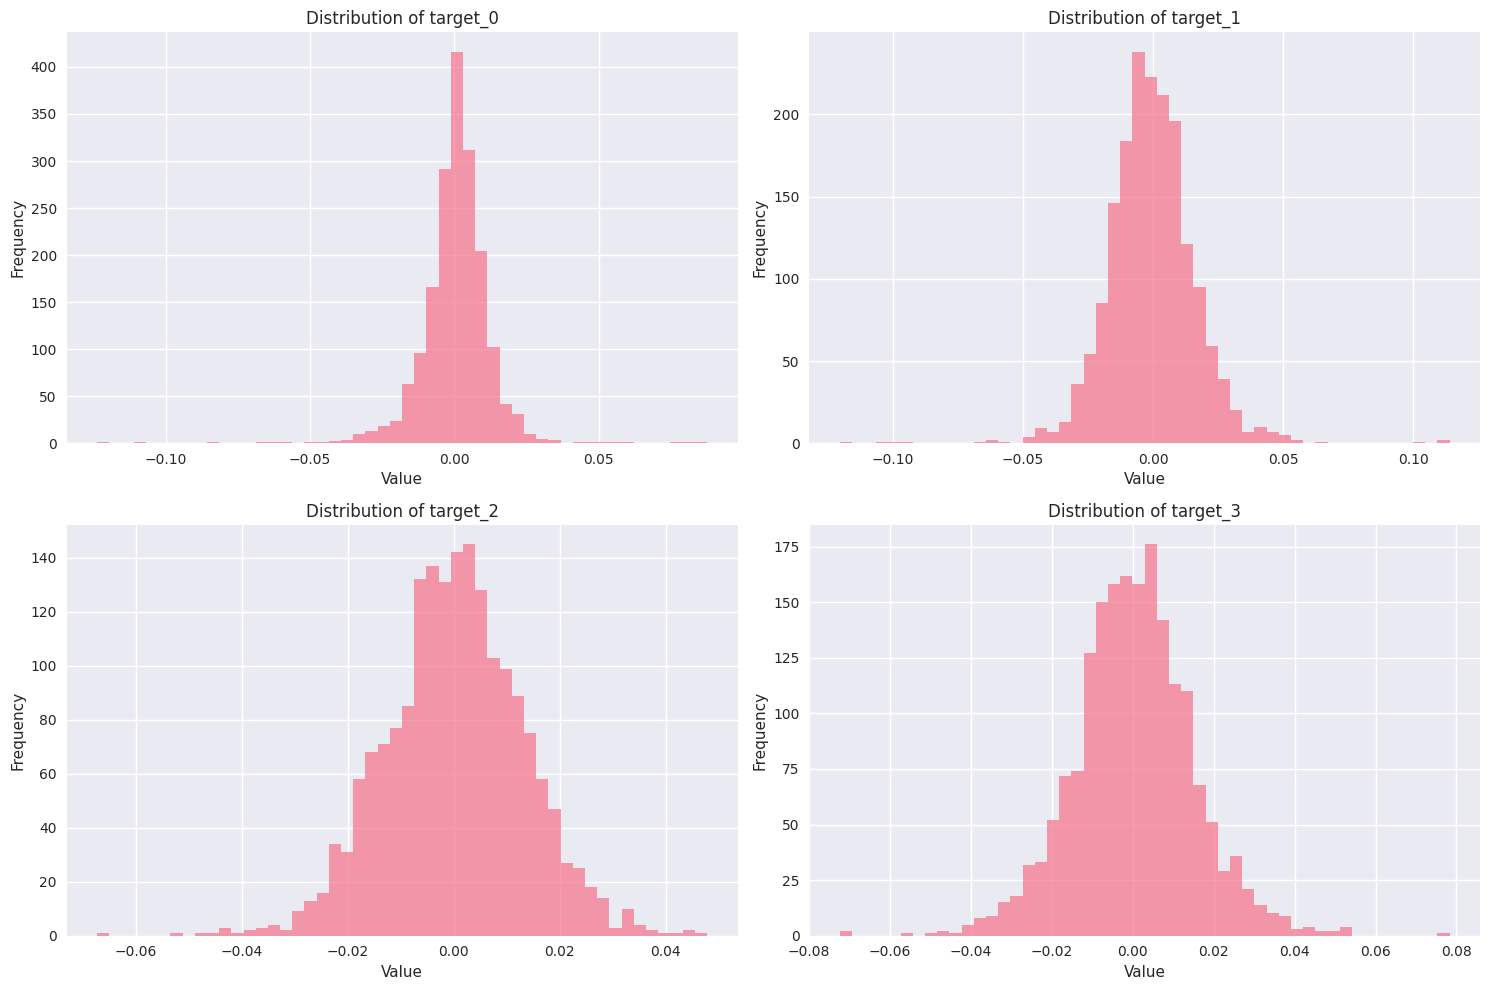

In [8]:
# Distribution of first few targets
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, target in enumerate(target_cols[:4]):
    labels[target].hist(bins=50, ax=axes[i], alpha=0.7)
    axes[i].set_title(f'Distribution of {target}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Target Pairs Analysis

In [9]:
target_pairs.head(10)

,target,lag,pair
0,target_0,1,US_Stock_VT_adj_close
1,target_1,1,LME_PB_Close - US_Stock_VT_adj_close
2,target_2,1,LME_CA_Close - LME_ZS_Close
3,target_3,1,LME_AH_Close - LME_ZS_Close
4,target_4,1,LME_AH_Close - JPX_Gold_Standard_Futures_Close
5,target_5,1,LME_ZS_Close - JPX_Platinum_Standard_Futures_C...
6,target_6,1,LME_PB_Close - LME_AH_Close
7,target_7,1,LME_ZS_Close - US_Stock_VYM_adj_close
8,target_8,1,US_Stock_IEMG_adj_close - JPX_Gold_Standard_Fu...
9,target_9,1,FX_AUDJPY - LME_PB_Close


Targets by lag:
lag
1    106
2    106
3    106
4    106
Name: count, dtype: int64


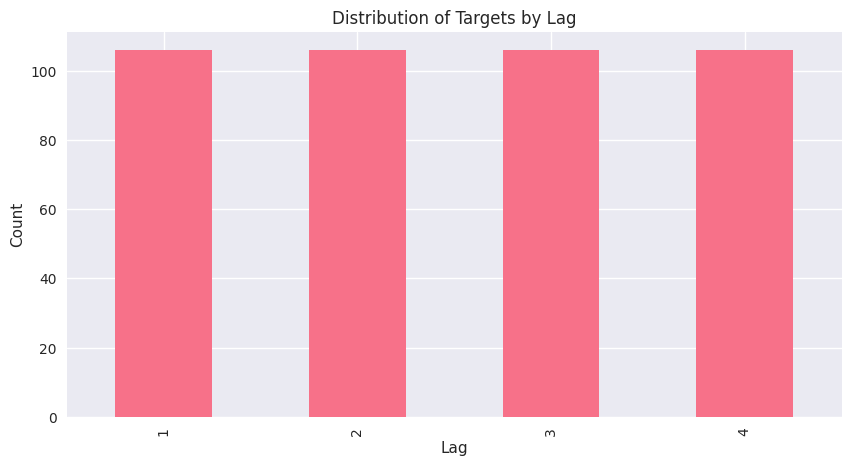

In [10]:
# Lag distribution
print('Targets by lag:')
print(target_pairs['lag'].value_counts().sort_index())

# Visualize
target_pairs['lag'].value_counts().sort_index().plot(kind='bar', figsize=(10, 5))
plt.title('Distribution of Targets by Lag')
plt.xlabel('Lag')
plt.ylabel('Count')
plt.show()

## Time Series Visualization

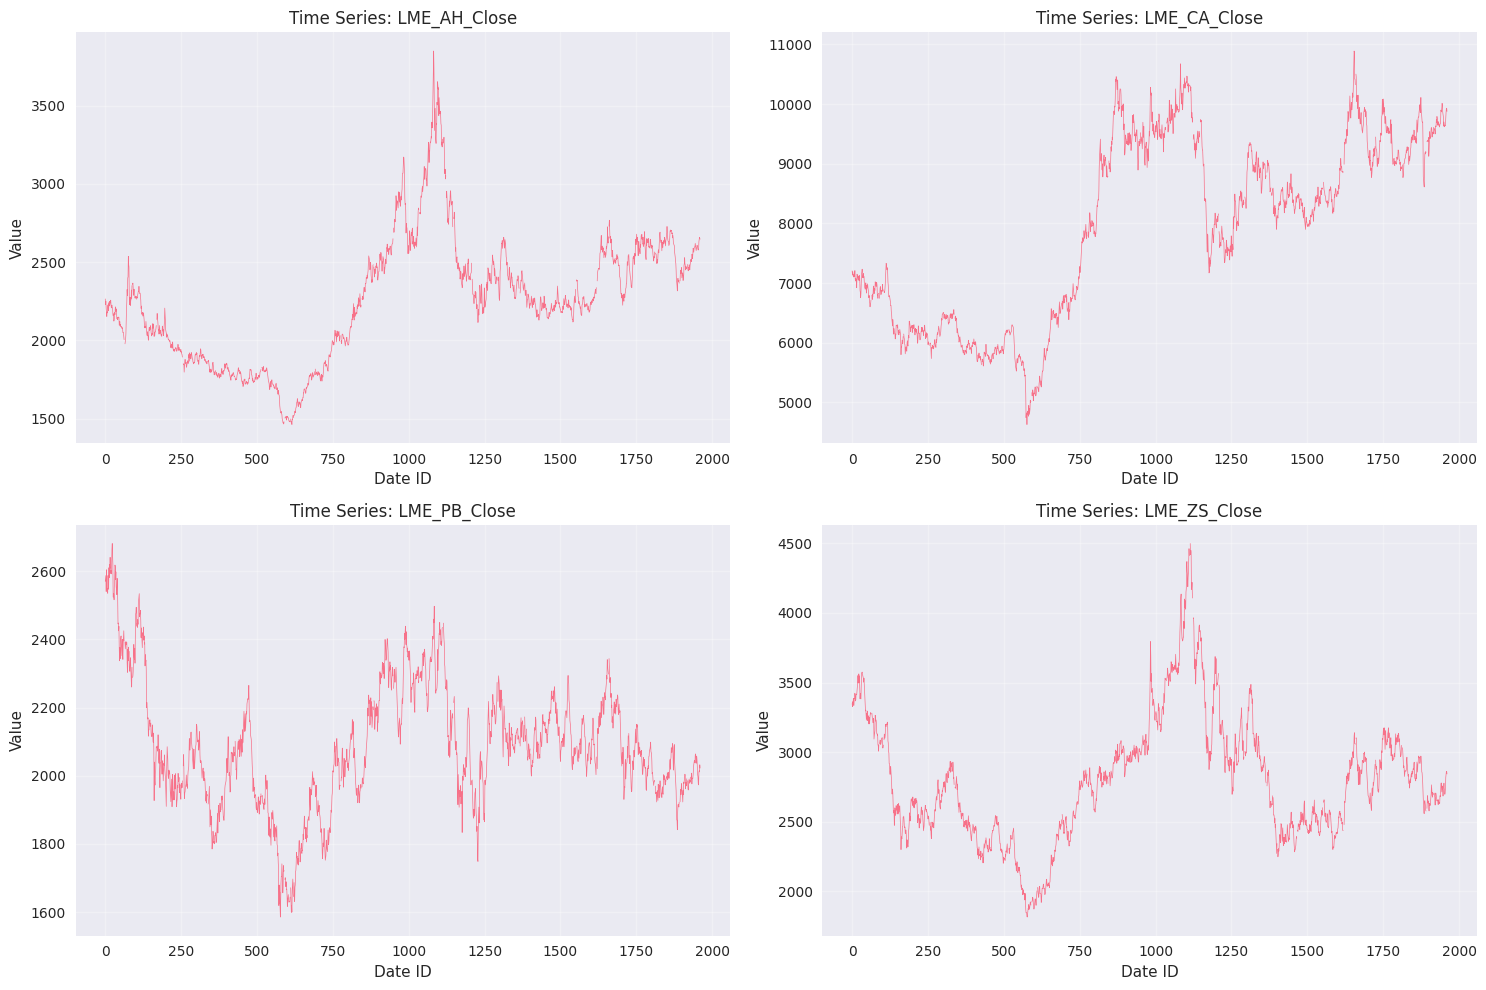

In [11]:
# Plot a few time series
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

sample_cols = ts_cols[:4]
for i, col in enumerate(sample_cols):
    axes[i].plot(train['date_id'], train[col], linewidth=0.5)
    axes[i].set_title(f'Time Series: {col}')
    axes[i].set_xlabel('Date ID')
    axes[i].set_ylabel('Value')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Next Steps

1. Feature engineering (lags, rolling stats, technical indicators)
2. Baseline model (simple LSTM or GradientBoosting)
3. Deep learning models (Transformer, TFT)
4. Ensemble

✓ Saved: eda_overview.png
✓ Saved: eda_missing.png


/tmp/ipykernel_1690245/2723221391.py:174: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([sample_targets[col].dropna() for col in sample_targets.columns],


✓ Saved: eda_targets.png


/tmp/ipykernel_1690245/2723221391.py:231: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lme_ah = train['LME_AH_Close'].fillna(method='ffill')
/tmp/ipykernel_1690245/2723221391.py:279: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = train[inst].fillna(method='ffill')
/tmp/ipykernel_1690245/2723221391.py:282: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  ax.plot(data_norm.values, linewidth=1.2, label=inst.split('_')[0:2], alpha=0.8)


✓ Saved: eda_timeseries.png


/tmp/ipykernel_1690245/2723221391.py:353: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature = train['LME_AH_Close'].fillna(method='ffill')


✓ Saved: eda_correlation.png

✓ All EDA visualizations created successfully!

Files saved:
  1. eda_overview.png - Обзор данных
  2. eda_missing.png - Анализ пропусков
  3. eda_targets.png - Распределение таргетов
  4. eda_timeseries.png - Анализ временных рядов
  5. eda_correlation.png - Корреляционный анализ


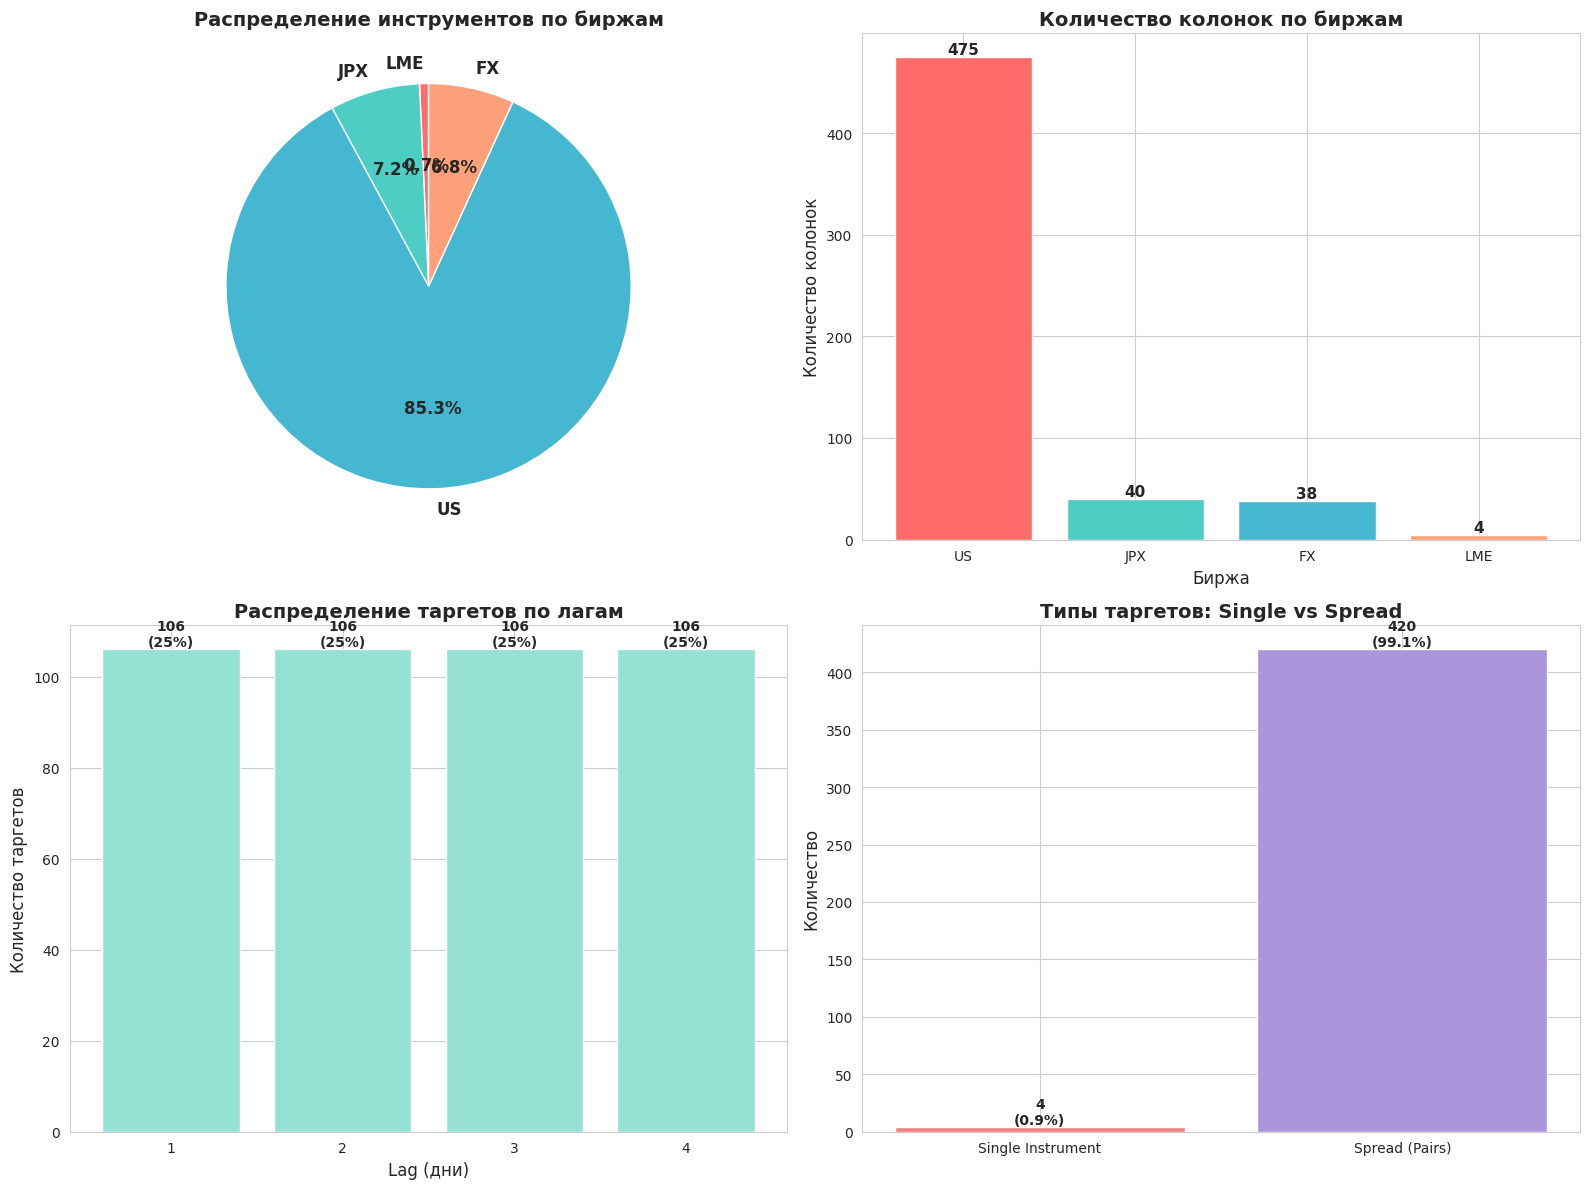

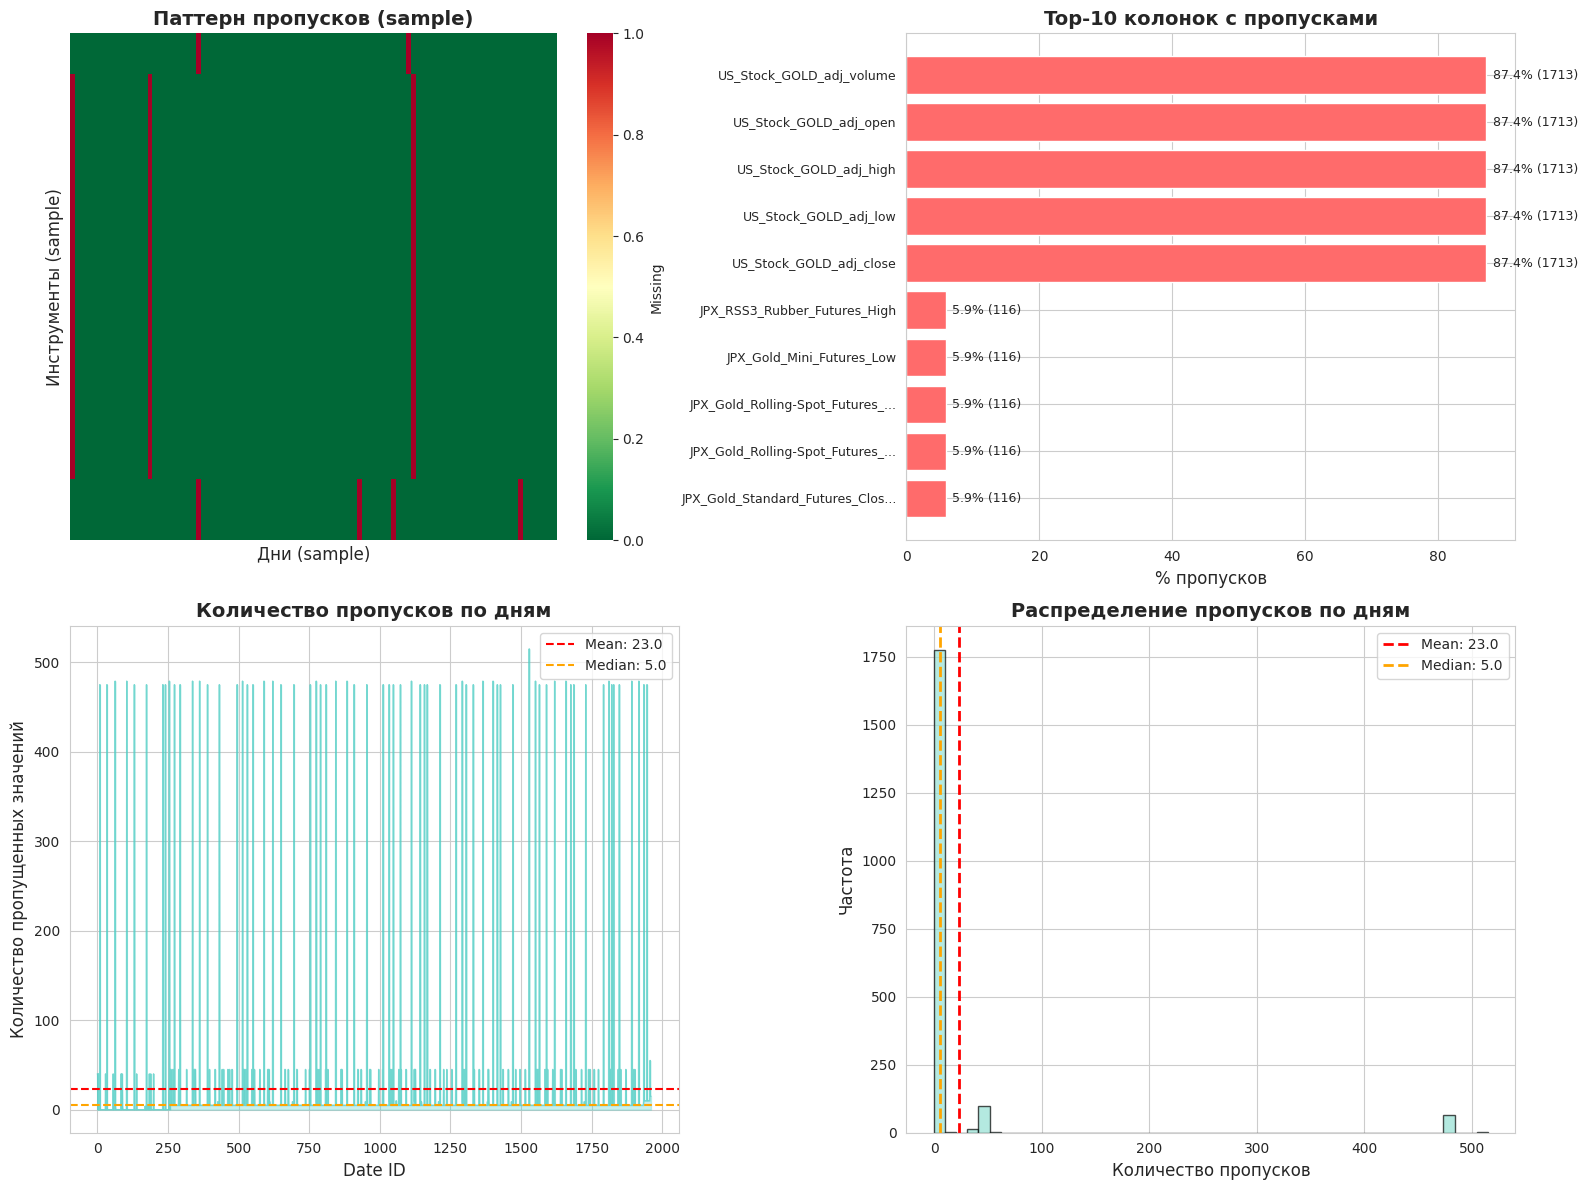

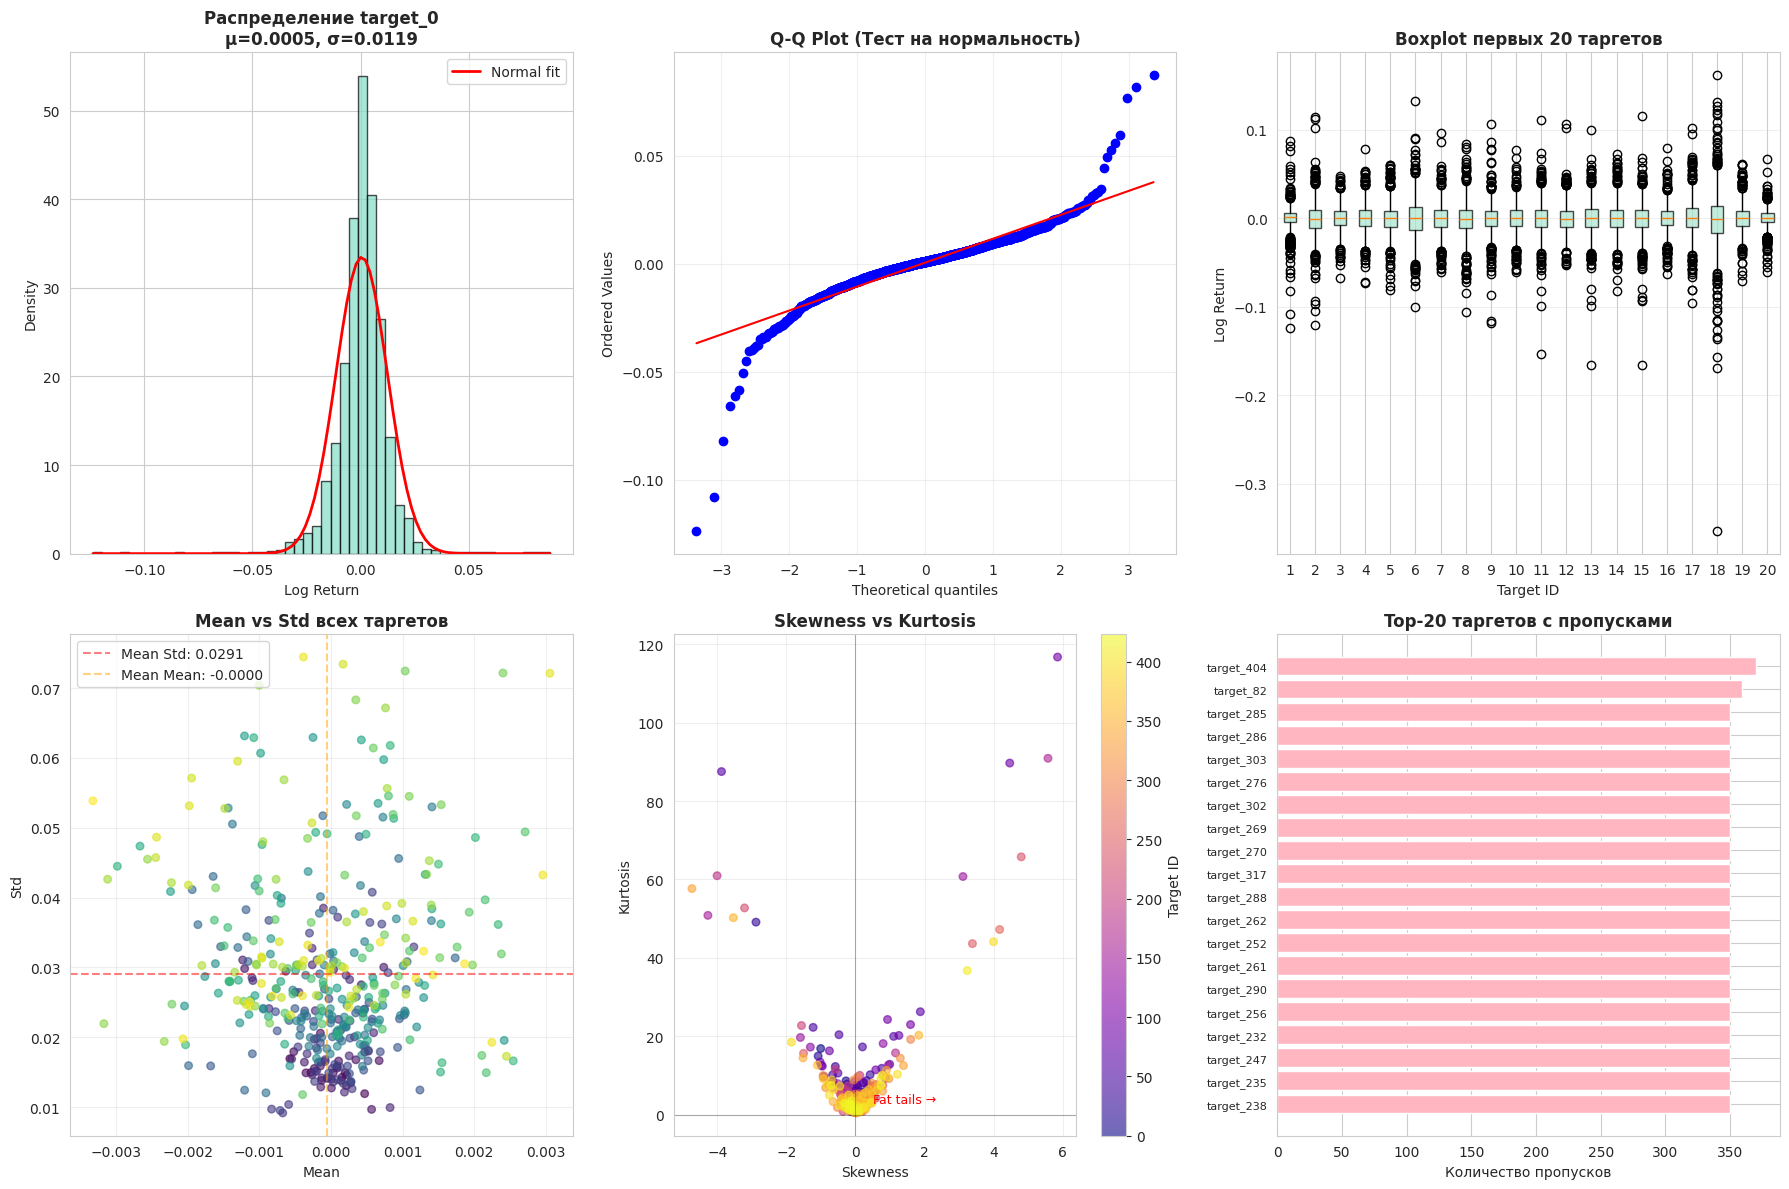

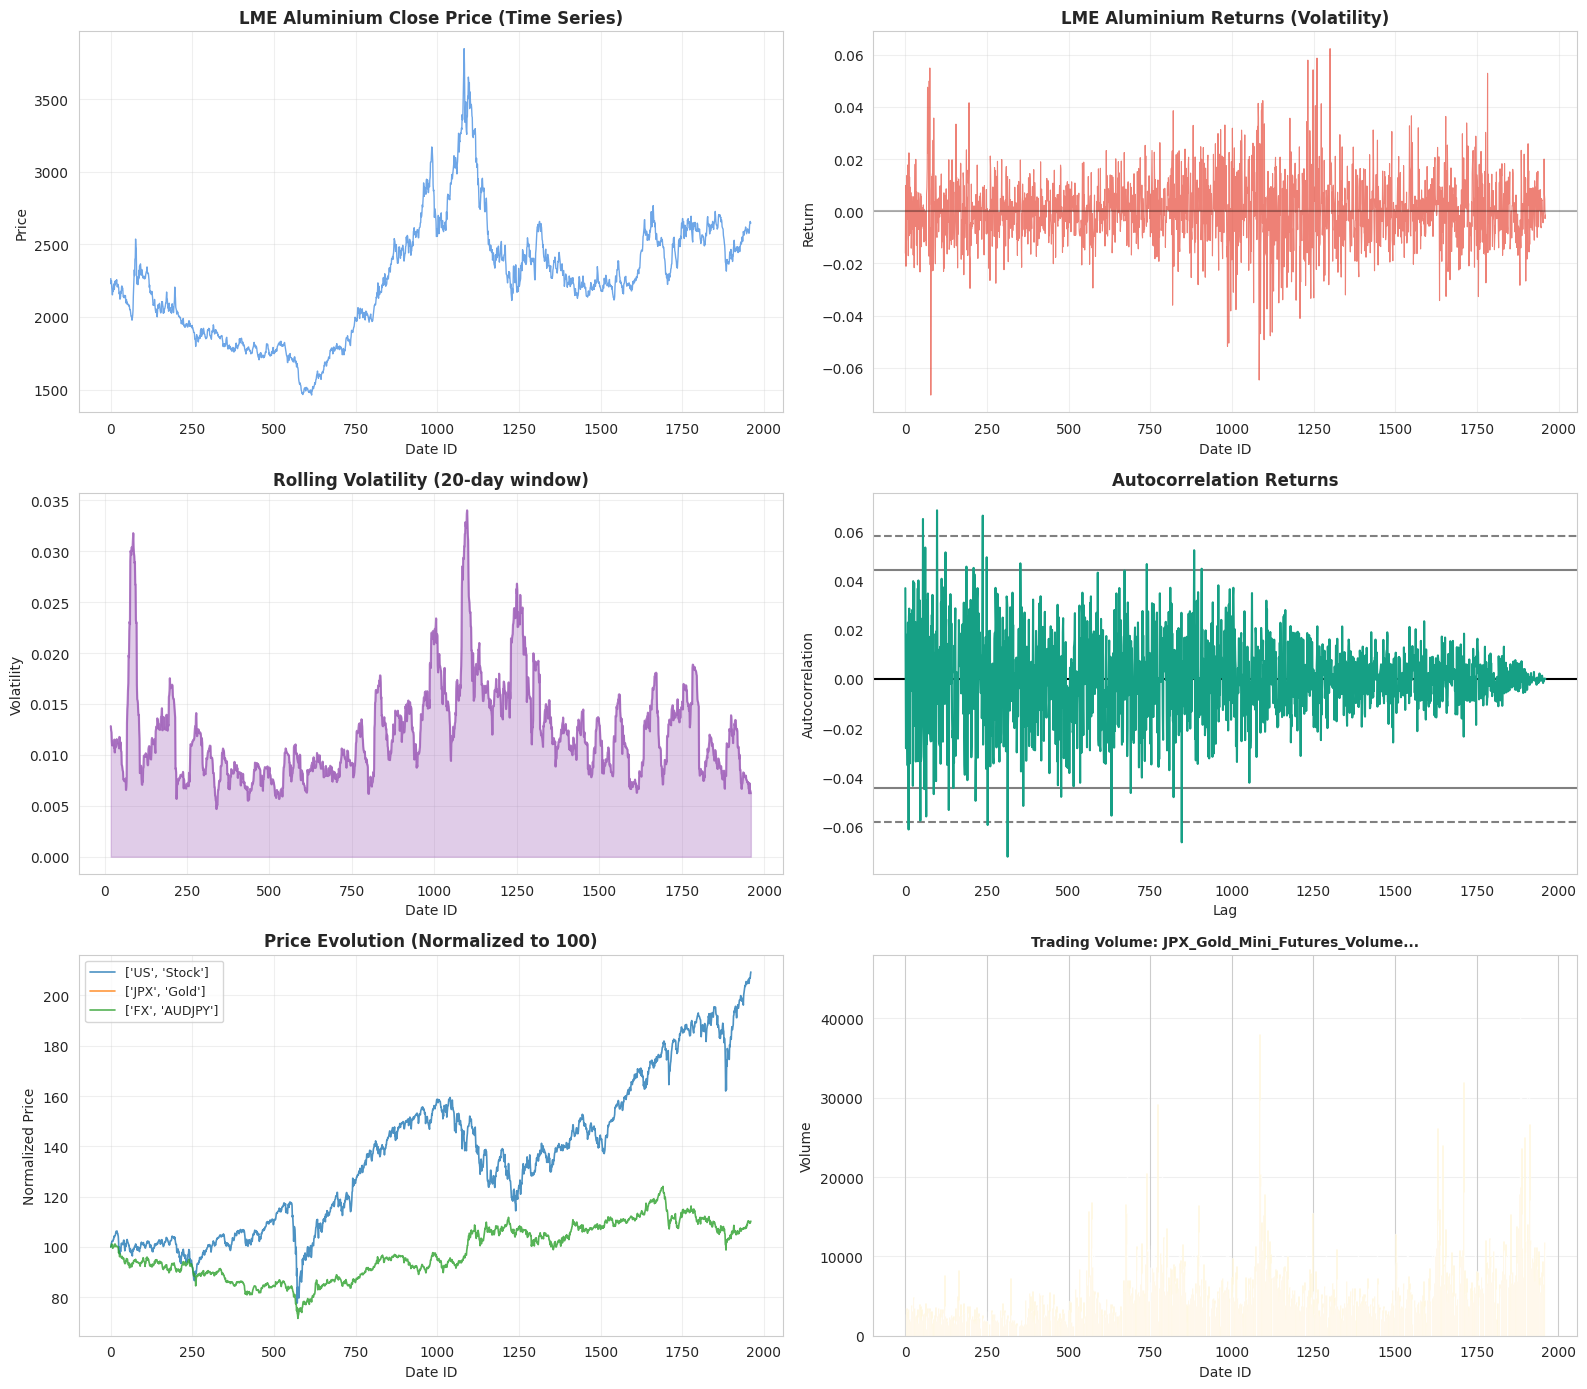

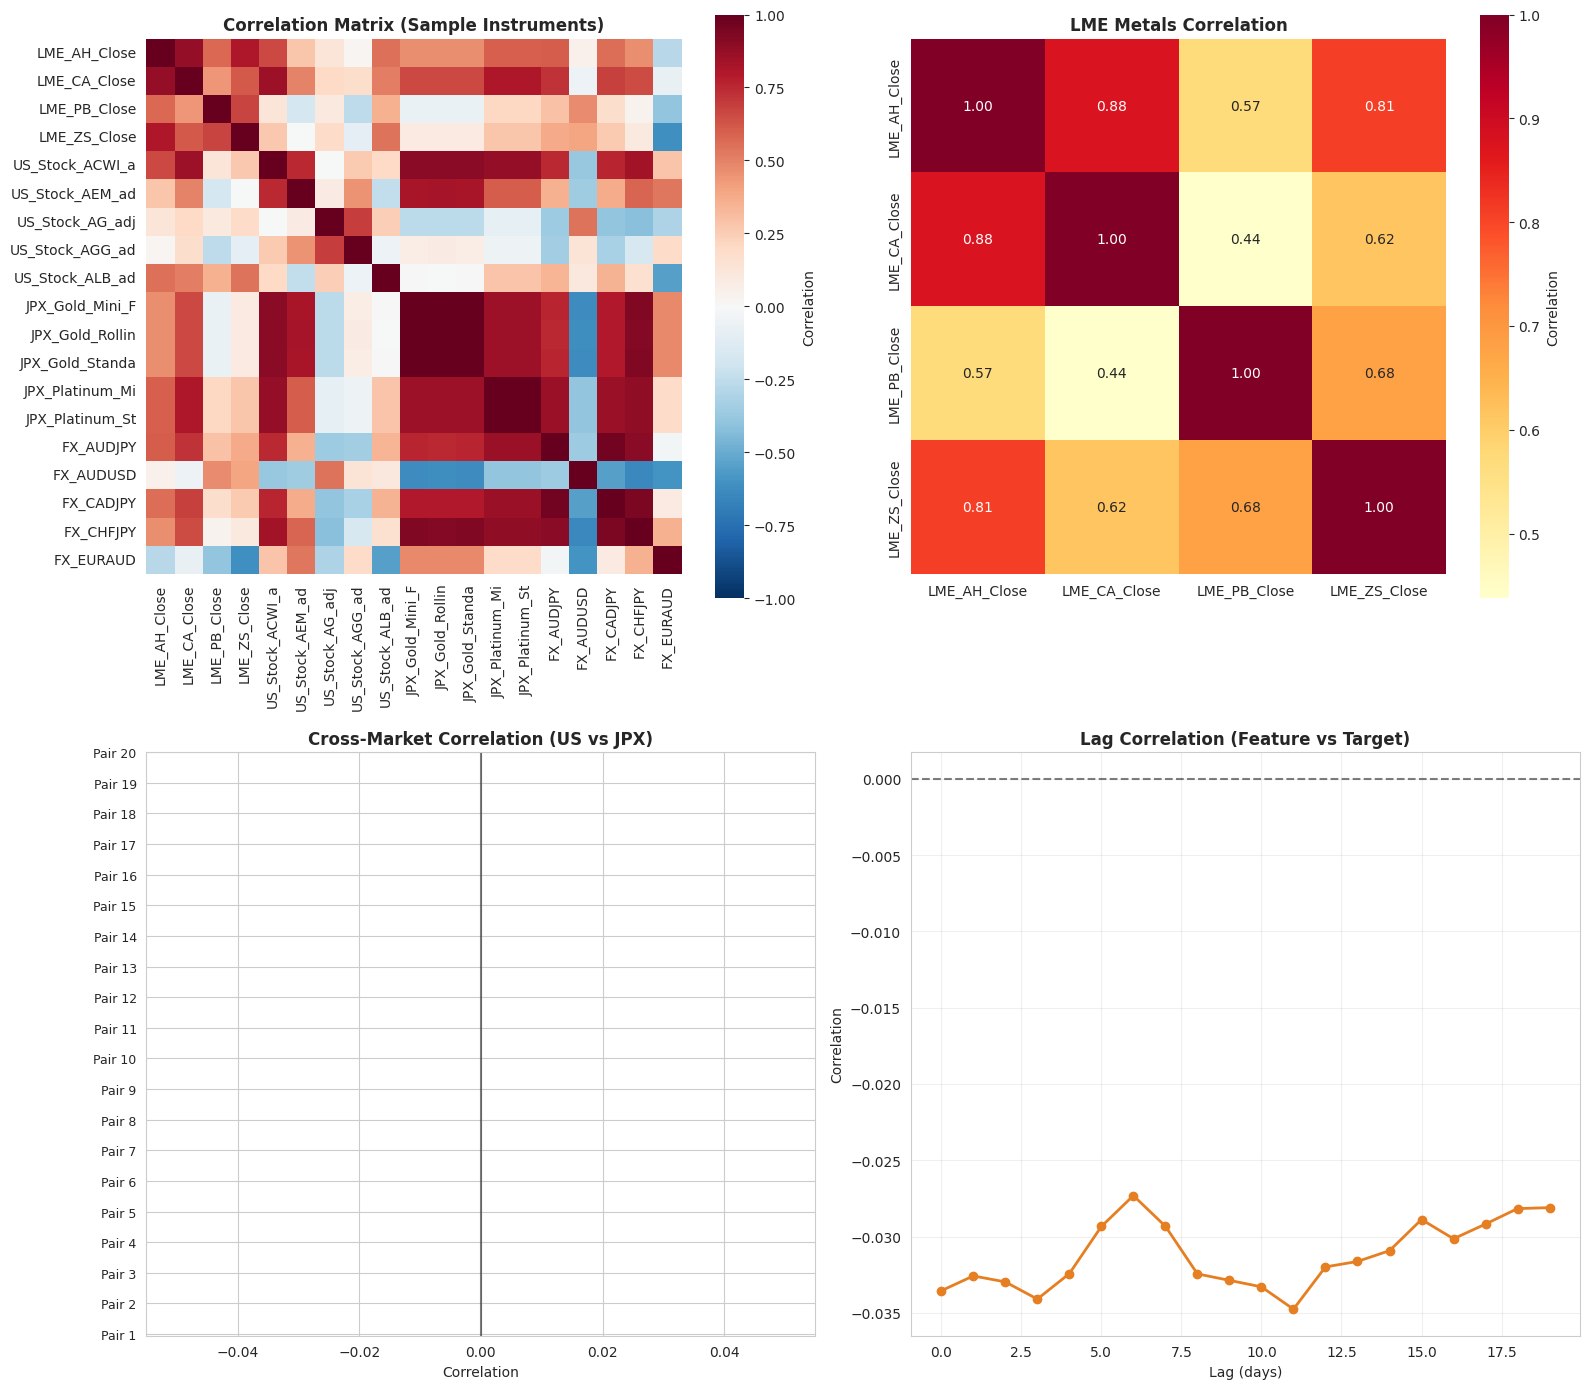

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Настройка стиля
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

base_path = "/home/nicolaedrabcinski/sd_kaggle/data"

# Загрузка данных
train = pd.read_csv(f"{base_path}/raw/train.csv")
train_labels = pd.read_csv(f"{base_path}/raw/train_labels.csv")
target_pairs = pd.read_csv(f"{base_path}/raw/target_pairs.csv")

# ==========================================
# ВИЗУАЛИЗАЦИЯ 1: Распределение по биржам
# ==========================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1.1 Pie chart - Распределение колонок по биржам
feature_cols = [c for c in train.columns if c != 'date_id']
prefixes = {}
for col in feature_cols:
    prefix = col.split('_')[0]
    prefixes[prefix] = prefixes.get(prefix, 0) + 1

ax = axes[0, 0]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
wedges, texts, autotexts = ax.pie(
    prefixes.values(), 
    labels=prefixes.keys(),
    autopct='%1.1f%%',
    colors=colors,
    startangle=90,
    textprops={'fontsize': 12, 'weight': 'bold'}
)
ax.set_title('Распределение инструментов по биржам', fontsize=14, weight='bold')

# 1.2 Bar chart - Количество колонок
ax = axes[0, 1]
sorted_prefixes = dict(sorted(prefixes.items(), key=lambda x: x[1], reverse=True))
bars = ax.bar(sorted_prefixes.keys(), sorted_prefixes.values(), color=colors)
ax.set_title('Количество колонок по биржам', fontsize=14, weight='bold')
ax.set_ylabel('Количество колонок', fontsize=12)
ax.set_xlabel('Биржа', fontsize=12)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=11, weight='bold')

# 1.3 Lag distribution
ax = axes[1, 0]
lag_counts = target_pairs['lag'].value_counts().sort_index()
bars = ax.bar(lag_counts.index, lag_counts.values, color='#95E1D3')
ax.set_title('Распределение таргетов по лагам', fontsize=14, weight='bold')
ax.set_xlabel('Lag (дни)', fontsize=12)
ax.set_ylabel('Количество таргетов', fontsize=12)
ax.set_xticks([1, 2, 3, 4])
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}\n(25%)', ha='center', va='bottom', fontsize=10, weight='bold')

# 1.4 Single vs Spread targets
ax = axes[1, 1]
single_count = (~target_pairs['pair'].str.contains(' - ')).sum()
spread_count = (target_pairs['pair'].str.contains(' - ')).sum()
bars = ax.bar(['Single Instrument', 'Spread (Pairs)'], 
              [single_count, spread_count], 
              color=['#F38181', '#AA96DA'])
ax.set_title('Типы таргетов: Single vs Spread', fontsize=14, weight='bold')
ax.set_ylabel('Количество', fontsize=12)
for bar in bars:
    height = bar.get_height()
    pct = height / len(target_pairs) * 100
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10, weight='bold')

plt.tight_layout()
plt.savefig(f'{base_path}/eda_overview.png', dpi=300, bbox_inches='tight')
print("✓ Saved: eda_overview.png")

# ==========================================
# ВИЗУАЛИЗАЦИЯ 2: Missing Values Analysis
# ==========================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 2.1 Heatmap пропусков по дням (sample)
ax = axes[0, 0]
sample_days = np.linspace(0, len(train)-1, 100).astype(int)
sample_cols = [c for c in feature_cols[:50]]  # первые 50 колонок
missing_matrix = train.iloc[sample_days][sample_cols].isnull().T
sns.heatmap(missing_matrix, cmap='RdYlGn_r', cbar_kws={'label': 'Missing'}, 
            ax=ax, xticklabels=False, yticklabels=False)
ax.set_title('Паттерн пропусков (sample)', fontsize=14, weight='bold')
ax.set_xlabel('Дни (sample)', fontsize=12)
ax.set_ylabel('Инструменты (sample)', fontsize=12)

# 2.2 Top missing columns
ax = axes[0, 1]
missing_by_col = train.isnull().sum().sort_values(ascending=False).head(10)
missing_pct = (missing_by_col / len(train) * 100)
bars = ax.barh(range(len(missing_pct)), missing_pct.values, color='#FF6B6B')
ax.set_yticks(range(len(missing_pct)))
ax.set_yticklabels([col[:30] + '...' if len(col) > 30 else col for col in missing_pct.index], fontsize=9)
ax.set_xlabel('% пропусков', fontsize=12)
ax.set_title('Top-10 колонок с пропусками', fontsize=14, weight='bold')
ax.invert_yaxis()
for i, (val, count) in enumerate(zip(missing_pct.values, missing_by_col.values)):
    ax.text(val + 1, i, f'{val:.1f}% ({count})', va='center', fontsize=9)

# 2.3 Missing по дням
ax = axes[1, 0]
missing_by_day = train.isnull().sum(axis=1)
ax.plot(missing_by_day.values, linewidth=1, color='#4ECDC4', alpha=0.7)
ax.fill_between(range(len(missing_by_day)), missing_by_day.values, alpha=0.3, color='#4ECDC4')
ax.set_title('Количество пропусков по дням', fontsize=14, weight='bold')
ax.set_xlabel('Date ID', fontsize=12)
ax.set_ylabel('Количество пропущенных значений', fontsize=12)
ax.axhline(y=missing_by_day.mean(), color='red', linestyle='--', 
           label=f'Mean: {missing_by_day.mean():.1f}')
ax.axhline(y=missing_by_day.median(), color='orange', linestyle='--',
           label=f'Median: {missing_by_day.median():.1f}')
ax.legend()

# 2.4 Распределение пропусков
ax = axes[1, 1]
ax.hist(missing_by_day.values, bins=50, color='#95E1D3', edgecolor='black', alpha=0.7)
ax.set_title('Распределение пропусков по дням', fontsize=14, weight='bold')
ax.set_xlabel('Количество пропусков', fontsize=12)
ax.set_ylabel('Частота', fontsize=12)
ax.axvline(x=missing_by_day.mean(), color='red', linestyle='--', linewidth=2,
           label=f'Mean: {missing_by_day.mean():.1f}')
ax.axvline(x=missing_by_day.median(), color='orange', linestyle='--', linewidth=2,
           label=f'Median: {missing_by_day.median():.1f}')
ax.legend()

plt.tight_layout()
plt.savefig(f'{base_path}/eda_missing.png', dpi=300, bbox_inches='tight')
print("✓ Saved: eda_missing.png")

# ==========================================
# ВИЗУАЛИЗАЦИЯ 3: Target Distribution Analysis
# ==========================================
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

targets = [c for c in train_labels.columns if c.startswith('target_')]

# 3.1 Distribution of target_0 (example)
ax = axes[0, 0]
target_data = train_labels['target_0'].dropna()
ax.hist(target_data, bins=50, color='#84DCC6', edgecolor='black', alpha=0.7, density=True)
mu, sigma = target_data.mean(), target_data.std()
x = np.linspace(target_data.min(), target_data.max(), 100)
ax.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal fit')
ax.set_title(f'Распределение target_0\nμ={mu:.4f}, σ={sigma:.4f}', fontsize=12, weight='bold')
ax.set_xlabel('Log Return', fontsize=10)
ax.set_ylabel('Density', fontsize=10)
ax.legend()

# 3.2 Q-Q plot для нормальности
ax = axes[0, 1]
stats.probplot(target_data, dist="norm", plot=ax)
ax.set_title('Q-Q Plot (Тест на нормальность)', fontsize=12, weight='bold')
ax.grid(True, alpha=0.3)

# 3.3 Boxplot всех таргетов (sample)
ax = axes[0, 2]
sample_targets = train_labels[targets[:20]].dropna()
ax.boxplot([sample_targets[col].dropna() for col in sample_targets.columns],
           labels=range(1, 21), patch_artist=True,
           boxprops=dict(facecolor='#A8E6CF', alpha=0.7))
ax.set_title('Boxplot первых 20 таргетов', fontsize=12, weight='bold')
ax.set_xlabel('Target ID', fontsize=10)
ax.set_ylabel('Log Return', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# 3.4 Mean and Std по таргетам
ax = axes[1, 0]
means = train_labels[targets].mean().values
stds = train_labels[targets].std().values
ax.scatter(means, stds, alpha=0.6, c=range(len(means)), cmap='viridis', s=30)
ax.set_title('Mean vs Std всех таргетов', fontsize=12, weight='bold')
ax.set_xlabel('Mean', fontsize=10)
ax.set_ylabel('Std', fontsize=10)
ax.axhline(y=stds.mean(), color='red', linestyle='--', alpha=0.5, label=f'Mean Std: {stds.mean():.4f}')
ax.axvline(x=means.mean(), color='orange', linestyle='--', alpha=0.5, label=f'Mean Mean: {means.mean():.4f}')
ax.legend()
ax.grid(True, alpha=0.3)

# 3.5 Skewness and Kurtosis
ax = axes[1, 1]
skewness = train_labels[targets].apply(lambda x: stats.skew(x.dropna()))
kurtosis = train_labels[targets].apply(lambda x: stats.kurtosis(x.dropna()))
scatter = ax.scatter(skewness, kurtosis, alpha=0.6, c=range(len(skewness)), cmap='plasma', s=30)
ax.set_title('Skewness vs Kurtosis', fontsize=12, weight='bold')
ax.set_xlabel('Skewness', fontsize=10)
ax.set_ylabel('Kurtosis', fontsize=10)
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=0.8)
ax.axvline(x=0, color='black', linestyle='-', alpha=0.3, linewidth=0.8)
ax.text(0.5, 3, 'Fat tails →', fontsize=9, color='red')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Target ID')

# 3.6 Missing in targets
ax = axes[1, 2]
missing_targets = train_labels[targets].isnull().sum().sort_values(ascending=False).head(20)
bars = ax.barh(range(len(missing_targets)), missing_targets.values, color='#FFB6C1')
ax.set_yticks(range(len(missing_targets)))
ax.set_yticklabels([f'target_{i}' for i in missing_targets.index.str.extract(r'(\d+)').values.flatten()], fontsize=8)
ax.set_xlabel('Количество пропусков', fontsize=10)
ax.set_title('Top-20 таргетов с пропусками', fontsize=12, weight='bold')
ax.invert_yaxis()

plt.tight_layout()
plt.savefig(f'{base_path}/eda_targets.png', dpi=300, bbox_inches='tight')
print("✓ Saved: eda_targets.png")

# ==========================================
# ВИЗУАЛИЗАЦИЯ 4: Time Series Analysis
# ==========================================
fig, axes = plt.subplots(3, 2, figsize=(16, 14))

# 4.1 Пример временного ряда (LME_AH_Close)
ax = axes[0, 0]
if 'LME_AH_Close' in train.columns:
    lme_ah = train['LME_AH_Close'].fillna(method='ffill')
    ax.plot(lme_ah.values, linewidth=1, color='#4A90E2', alpha=0.8)
    ax.set_title('LME Aluminium Close Price (Time Series)', fontsize=12, weight='bold')
    ax.set_xlabel('Date ID', fontsize=10)
    ax.set_ylabel('Price', fontsize=10)
    ax.grid(True, alpha=0.3)

# 4.2 Returns для LME_AH
ax = axes[0, 1]
if 'LME_AH_Close' in train.columns:
    returns = lme_ah.pct_change().dropna()
    ax.plot(returns.values, linewidth=0.8, color='#E74C3C', alpha=0.7)
    ax.set_title('LME Aluminium Returns (Volatility)', fontsize=12, weight='bold')
    ax.set_xlabel('Date ID', fontsize=10)
    ax.set_ylabel('Return', fontsize=10)
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax.grid(True, alpha=0.3)

# 4.3 Rolling volatility
ax = axes[1, 0]
if 'LME_AH_Close' in train.columns:
    rolling_vol = returns.rolling(window=20).std()
    ax.plot(rolling_vol.values, linewidth=1.5, color='#9B59B6', alpha=0.8)
    ax.fill_between(range(len(rolling_vol)), rolling_vol.values, alpha=0.3, color='#9B59B6')
    ax.set_title('Rolling Volatility (20-day window)', fontsize=12, weight='bold')
    ax.set_xlabel('Date ID', fontsize=10)
    ax.set_ylabel('Volatility', fontsize=10)
    ax.grid(True, alpha=0.3)

# 4.4 Autocorrelation для returns
ax = axes[1, 1]
if 'LME_AH_Close' in train.columns:
    from pandas.plotting import autocorrelation_plot
    autocorrelation_plot(returns, ax=ax, color='#16A085')
    ax.set_title('Autocorrelation Returns', fontsize=12, weight='bold')
    ax.set_xlabel('Lag', fontsize=10)
    ax.set_ylabel('Autocorrelation', fontsize=10)

# 4.5 Comparison US vs JPX vs FX (sample instruments)
ax = axes[2, 0]
instruments_to_plot = []
for prefix in ['US_Stock', 'JPX_Gold', 'FX_']:
    cols = [c for c in train.columns if c.startswith(prefix)]
    if cols:
        instruments_to_plot.append(cols[0])

if len(instruments_to_plot) >= 3:
    for inst in instruments_to_plot[:3]:
        data = train[inst].fillna(method='ffill')
        # Normalize to 100
        data_norm = (data / data.iloc[0]) * 100
        ax.plot(data_norm.values, linewidth=1.2, label=inst.split('_')[0:2], alpha=0.8)
    ax.set_title('Price Evolution (Normalized to 100)', fontsize=12, weight='bold')
    ax.set_xlabel('Date ID', fontsize=10)
    ax.set_ylabel('Normalized Price', fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

# 4.6 Volume analysis (if available)
ax = axes[2, 1]
volume_cols = [c for c in train.columns if 'volume' in c.lower()]
if volume_cols:
    sample_vol = train[volume_cols[0]].fillna(0)
    ax.bar(range(len(sample_vol)), sample_vol.values, color='#FFC300', alpha=0.7, width=1)
    ax.set_title(f'Trading Volume: {volume_cols[0][:40]}...', fontsize=10, weight='bold')
    ax.set_xlabel('Date ID', fontsize=10)
    ax.set_ylabel('Volume', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
else:
    ax.text(0.5, 0.5, 'No volume data available', ha='center', va='center',
            transform=ax.transAxes, fontsize=12)

plt.tight_layout()
plt.savefig(f'{base_path}/eda_timeseries.png', dpi=300, bbox_inches='tight')
print("✓ Saved: eda_timeseries.png")

# ==========================================
# ВИЗУАЛИЗАЦИЯ 5: Correlation Analysis
# ==========================================
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 5.1 Correlation matrix (sample instruments)
ax = axes[0, 0]
sample_instruments = []
for prefix in ['LME_', 'US_Stock', 'JPX_', 'FX_']:
    cols = [c for c in feature_cols if c.startswith(prefix)]
    if cols:
        sample_instruments.extend(cols[:5])

corr_matrix = train[sample_instruments[:20]].corr()
sns.heatmap(corr_matrix, cmap='RdBu_r', center=0, vmin=-1, vmax=1,
            square=True, ax=ax, cbar_kws={'label': 'Correlation'},
            xticklabels=[c[:15] for c in corr_matrix.columns],
            yticklabels=[c[:15] for c in corr_matrix.columns])
ax.set_title('Correlation Matrix (Sample Instruments)', fontsize=12, weight='bold')

# 5.2 LME metals correlation
ax = axes[0, 1]
lme_cols = [c for c in train.columns if c.startswith('LME_') and 'Close' in c]
if len(lme_cols) >= 2:
    lme_corr = train[lme_cols].corr()
    sns.heatmap(lme_corr, annot=True, fmt='.2f', cmap='YlOrRd', square=True, ax=ax,
                cbar_kws={'label': 'Correlation'})
    ax.set_title('LME Metals Correlation', fontsize=12, weight='bold')

# 5.3 Cross-market correlation (US vs JPX)
ax = axes[1, 0]
us_sample = [c for c in feature_cols if c.startswith('US_Stock')][:10]
jpx_sample = [c for c in feature_cols if c.startswith('JPX_')][:10]

if us_sample and jpx_sample:
    cross_corr = train[us_sample].corrwith(train[jpx_sample], axis=0, method='pearson')
    bars = ax.barh(range(len(cross_corr)), cross_corr.values, color='#3498DB')
    ax.set_yticks(range(len(cross_corr)))
    ax.set_yticklabels([f'Pair {i+1}' for i in range(len(cross_corr))], fontsize=9)
    ax.set_xlabel('Correlation', fontsize=10)
    ax.set_title('Cross-Market Correlation (US vs JPX)', fontsize=12, weight='bold')
    ax.axvline(x=0, color='black', linestyle='-', alpha=0.5)

# 5.4 Correlation lag analysis (target vs features)
ax = axes[1, 1]
if 'LME_AH_Close' in train.columns and 'target_0' in train_labels.columns:
    feature = train['LME_AH_Close'].fillna(method='ffill')
    target = train_labels['target_0']
    
    # Compute correlation at different lags
    lags = range(0, 20)
    correlations = []
    for lag in lags:
        if lag == 0:
            corr = feature.corr(target)
        else:
            corr = feature.shift(lag).corr(target)
        correlations.append(corr)
    
    ax.plot(lags, correlations, marker='o', linewidth=2, markersize=6, color='#E67E22')
    ax.set_title('Lag Correlation (Feature vs Target)', fontsize=12, weight='bold')
    ax.set_xlabel('Lag (days)', fontsize=10)
    ax.set_ylabel('Correlation', fontsize=10)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{base_path}/eda_correlation.png', dpi=300, bbox_inches='tight')
print("✓ Saved: eda_correlation.png")

print("\n" + "="*60)
print("✓ All EDA visualizations created successfully!")
print("="*60)
print("\nFiles saved:")
print("  1. eda_overview.png - Обзор данных")
print("  2. eda_missing.png - Анализ пропусков")
print("  3. eda_targets.png - Распределение таргетов")
print("  4. eda_timeseries.png - Анализ временных рядов")
print("  5. eda_correlation.png - Корреляционный анализ")